# Dealiasing the data
- **Note** : The data should be periodic in x and y domain

### Validating dealiasing with $\sin() / \cos()$ examples

Error in dealiasing:  5.773159728050814e-15


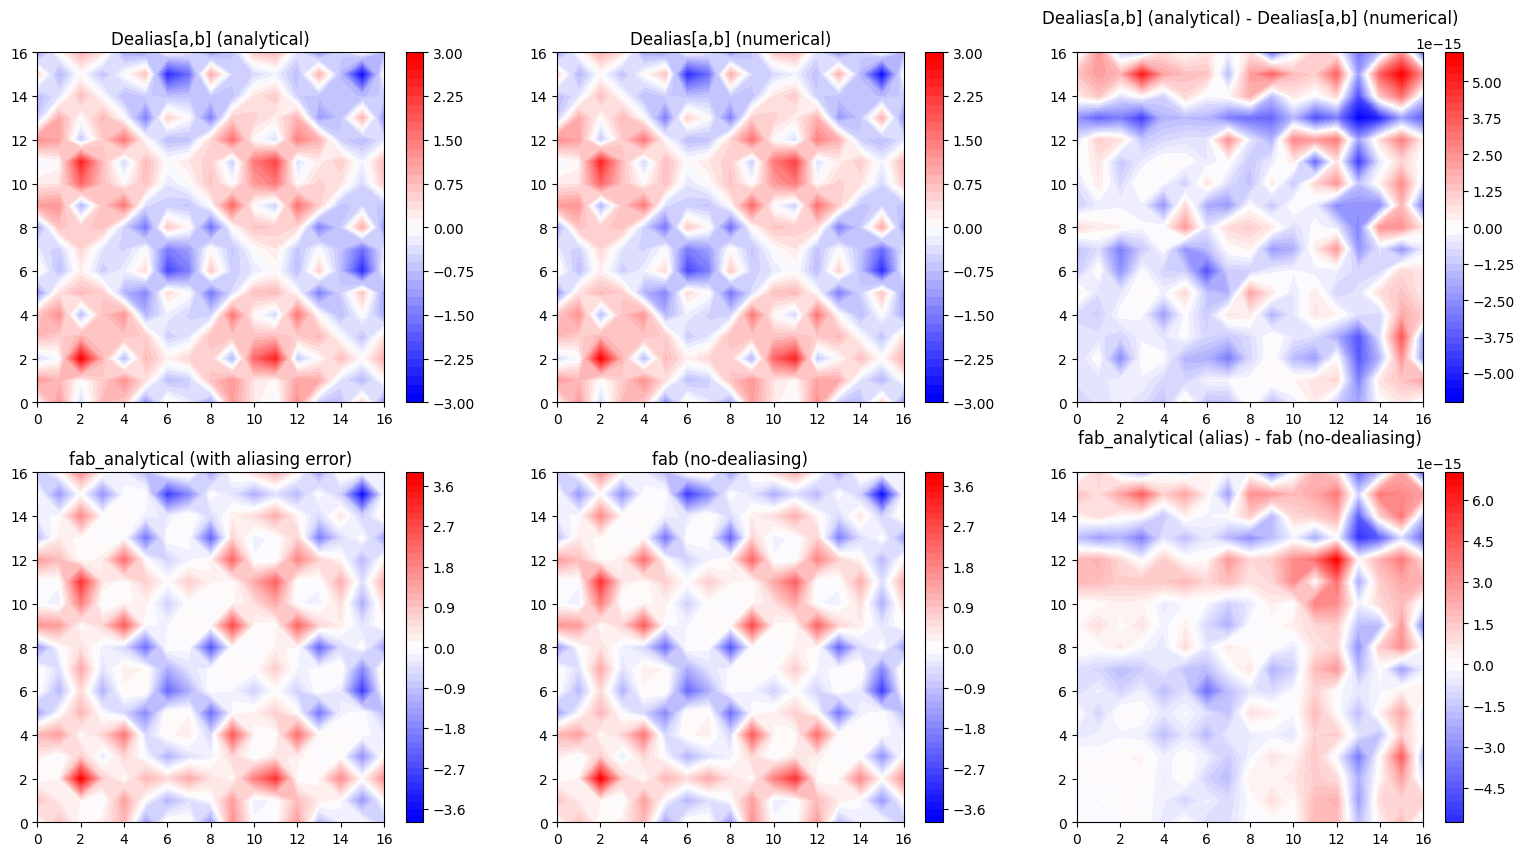

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from py2d.initialize import gridgen
from py2d.dealias import multiply_dealias, padding_for_dealias
from py2d.filter import coarse_spectral_filter_square

Lx, Ly = 2*np.pi, 2*np.pi

Nx, Ny = 17,17

Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')

# Analytical Sine and Cosine expressions with and without dealiasing
def exp1(X):
    k = X.shape[0]//2
    A = 2*k
    a = np.sin((3*A/8)*X) 
    b = np.cos((2*A/8)*X)

    # Multiply the two functions and expanding using trigonometric identities
    ab_alias = 1/2*(np.sin((5*A/8)*X) + np.sin((1*A/8)*X))

    # Exclusing the Aliasing error: sin(T X) is aliasing error with T>A/2. 
    # A is length of array. A/2 is the Nyquist frequency
    ab = 1/2*(np.sin((A/8)*X))

    return a, b, ab, ab_alias

def exp2(X,Y):
    k = X.shape[0]//2
    A = 2*k
    a = np.sin((3*A/8)*X) + np.sin((3*A/8)*Y)
    b = np.cos((2*A/8)*X) + np.cos((2*A/8)*Y)

    # Multiply the two functions and expanding using trigonometric identities
    ab_alias = 1/2*(np.sin((5*A/8)*X) + np.sin((A/8)*X)) + 1/2*((np.sin((5*A/8)*Y) + np.sin((A/8)*Y))) + 1/2*(
        np.sin((3*A*X + 2*A*Y)/8) + np.sin((3*A*X-2*A*Y)/8) + np.sin((3*A*Y + 2*A*X)/8) + np.sin((3*A*Y - 2*A*X)/8))
    
    # Exclusing the Aliasing error: sin(T X) is aliasing error with T>A/2. 
    # A is length of array. A/2 is the Nyquist frequency
    ab = 1/2*( np.sin((A/8)*X)) + 1/2*( np.sin((A/8)*Y)) + 1/2*(
        np.sin((3*A*X + 2*A*Y)/8) + np.sin((3*A*X-2*A*Y)/8) + np.sin((3*A*Y + 2*A*X)/8) + np.sin((3*A*Y - 2*A*X)/8))
    return a, b, ab, ab_alias

fa, fb, fab_analytical, fab_analytical_alias = exp2(X,Y)

fab = fa*fb
fab_dealiased = multiply_dealias(fa, fb, dealias=True)


# Plot contours of fab_analytical, fab, and fab_dealiased
fig, axs = plt.subplots(2, 3, figsize=(19, 10))

vmax = np.max(fab_analytical)
vmin = -vmax

c1 = axs[0,0].contourf(fab_analytical, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c1, ax=axs[0,0])
axs[0,0].set_title('Dealias[a,b] (analytical)')

c2 = axs[0,1].contourf(fab_dealiased, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c2, ax=axs[0,1])
axs[0,1].set_title('Dealias[a,b] (numerical)')

vmax = np.max(fab_analytical-fab_dealiased)
vmin = -vmax
c3 = axs[0,2].contourf(fab_analytical-fab_dealiased, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c3, ax=axs[0,2])
axs[0,2].set_title('Dealias[a,b] (analytical) - Dealias[a,b] (numerical)\n')

vmax = np.max(fab_analytical_alias)
vmin = -vmax
c4 = axs[1,0].contourf(fab_analytical_alias, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c4, ax=axs[1,0])
axs[1,0].set_title('fab_analytical (with aliasing error)')

c5 = axs[1,1].contourf(fab, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c5, ax=axs[1,1])
axs[1,1].set_title('fab (no-dealiasing)')

vmax = np.max(fab_analytical_alias-fab)
vmin = -vmax
c6 = axs[1,2].contourf(fab_analytical_alias-fab, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c6, ax=axs[1,2])
axs[1,2].set_title('fab_analytical (alias) - fab (no-dealiasing)\n')

print('Error in dealiasing: ', np.max(np.abs(fab_analytical-fab_dealiased)))

### Dealias[a,b,c] != Dealias[Dealias[a,b],c]

Text(0.5, 1.0, 'Dealias[a,b,c] (analytical) - Dealias[Dealias[a,b],c] (numerical)\n')

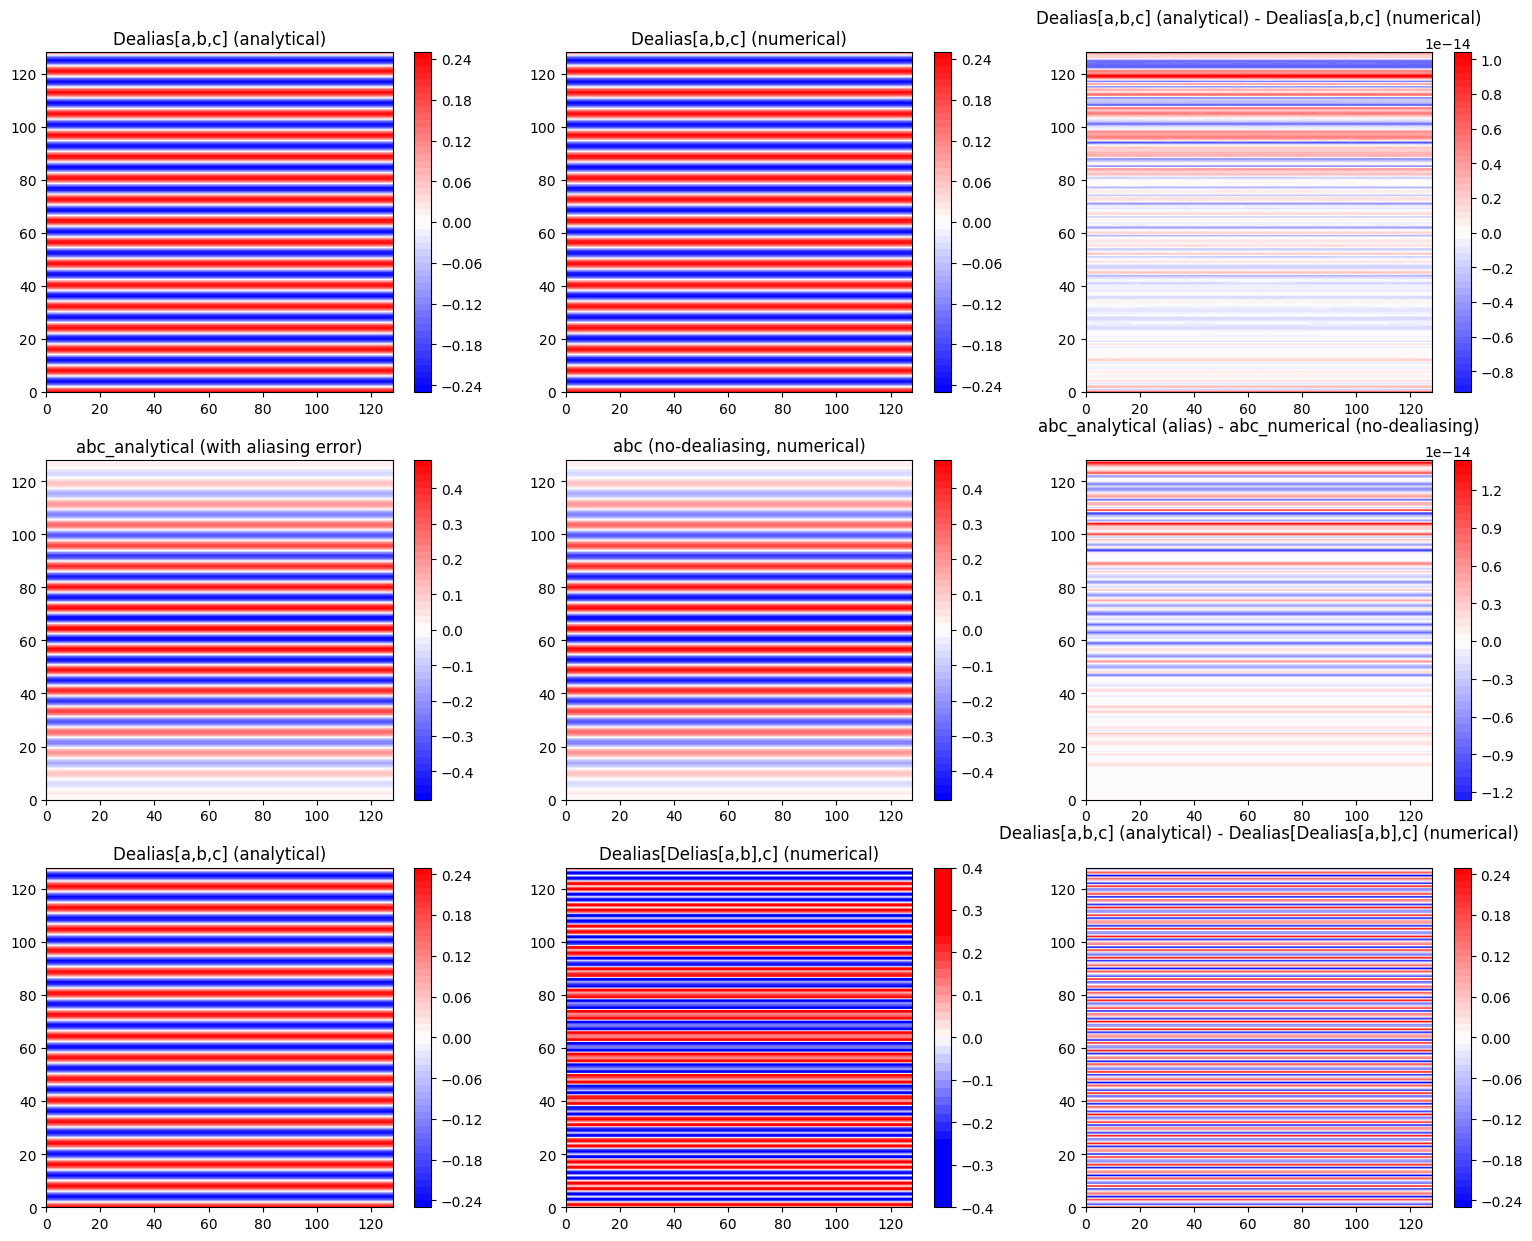

In [15]:
Lx, Ly = 2*np.pi, 2*np.pi

Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')

def exp3(X):
    k = X.shape[0]//2
    a = np.sin(3*k/4*X)
    b = np.cos(2*k/4*X)
    c = np.sin(2*k/4*X)

    abc_analytical = 1/4*(np.cos(k*X/4)-np.cos(3*k*X/4))
    acb_analytical = 1/4*(np.cos(k*X/4)+np.cos(3*k*X/4))
    bca_analytical = 1/4*(np.cos(k*X/4))
    abc_analytical_dealias = 1/4*(np.cos(k*X/4))
    abc_analytical_alias = 1/4*(np.cos(k*X/4) - np.cos(7*(k*X/4)))

    return a, b, c, abc_analytical, acb_analytical, bca_analytical, abc_analytical_dealias, abc_analytical_alias

a,b,c, abc_A, acb_A, bca_A, abc_A, abc_A_alias = exp3(X)

ab_dealias = multiply_dealias(a, b, dealias=True)
ac_dealias = multiply_dealias(a, c, dealias=True)
bc_dealias = multiply_dealias(b, c, dealias=True)

abc_dealias = multiply_dealias(ab_dealias, c, dealias=True)
acb_dealias = multiply_dealias(ac_dealias, b, dealias=True)
bca_dealias = multiply_dealias(bc_dealias, a, dealias=True)

abc = a*b*c

# Dealias each field
a_dealias = padding_for_dealias(a, spectral=False)
b_dealias = padding_for_dealias(b, spectral=False)
c_dealias = padding_for_dealias(c, spectral=False)

abc_dealias_hat = np.fft.rfft2(a_dealias*b_dealias*c_dealias)
# Multiply on the dealise grid and coarse grain to alias grid
abc_proper_dealias_hat = coarse_spectral_filter_square(abc_dealias_hat, a.shape[0])
abc_proper_dealias = np.fft.irfft2(abc_proper_dealias_hat, s=(a.shape[0], a.shape[0]))

# Plot contours of fab_analytical, fab, and fab_dealiased
fig, axs = plt.subplots(3, 3, figsize=(19, 15))

vmax = np.max(abc_A)
vmin = -vmax

c1 = axs[0,0].contourf(abc_A, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c1, ax=axs[0,0])
axs[0,0].set_title('Dealias[a,b,c] (analytical)')

c2 = axs[0,1].contourf(abc_proper_dealias, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c2, ax=axs[0,1])
axs[0,1].set_title('Dealias[a,b,c] (numerical)')

vmax = np.max(abc_A-abc_proper_dealias)
vmin = -vmax
c3 = axs[0,2].contourf(abc_A-abc_proper_dealias, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c3, ax=axs[0,2])
axs[0,2].set_title('Dealias[a,b,c] (analytical) - Dealias[a,b,c] (numerical)\n')

vmax = np.max(abc_A_alias)
vmin = -vmax
c4 = axs[1,0].contourf(abc_A_alias, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c4, ax=axs[1,0])
axs[1,0].set_title('abc_analytical (with aliasing error)')

c5 = axs[1,1].contourf(abc, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c5, ax=axs[1,1])
axs[1,1].set_title('abc (no-dealiasing, numerical)')

vmax = np.max(abc_A_alias-abc)
vmin = -vmax
c6 = axs[1,2].contourf(abc_A_alias-abc, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c6, ax=axs[1,2])
axs[1,2].set_title('abc_analytical (alias) - abc_numerical (no-dealiasing)\n')

vmax = np.max(abc_A)
vmin = -vmax
c7 = axs[2,0].contourf(abc_A, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c7, ax=axs[2,0])
axs[2,0].set_title('Dealias[a,b,c] (analytical)')

c8 = axs[2,1].contourf(abc_dealias, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c8, ax=axs[2,1])
axs[2,1].set_title('Dealias[Delias[a,b],c] (numerical)')

vmax = np.max(abc_A-abc_dealias)
vmin = -vmax
c9 = axs[2,2].contourf(abc_A-abc_dealias, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(c9, ax=axs[2,2])
axs[2,2].set_title('Dealias[a,b,c] (analytical) - Dealias[Dealias[a,b],c] (numerical)\n')

### Comparison of aliased term with dealiased using numpy and jax

Compare Numpy and Jax dealiasing 
 MSE : 2.3404173512016125e-31, Correlation coefficient: 0.9999999999999997, Max difference: 1.7763568394002505e-15


Text(0.5, 1.0, 'fab (numpy) - fab (jax)')

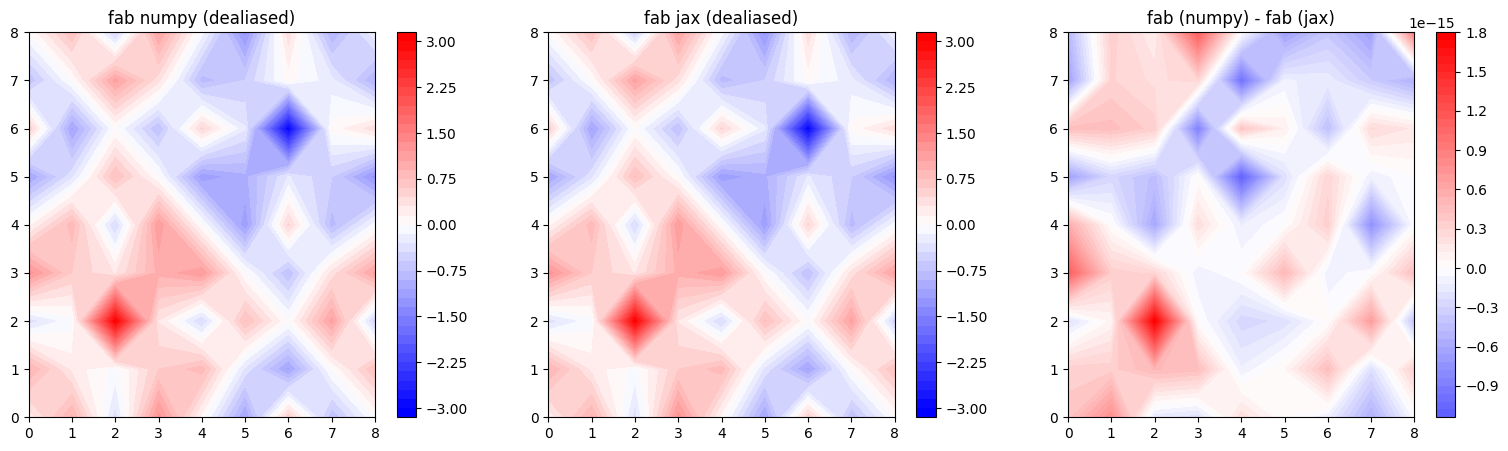

In [11]:
import jax.numpy as jnp
import jax
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

from py2d.dealias import multiply_dealias_physical_jit
from py2d.initialize import gridgen

Lx, Ly = 2*np.pi, 2*np.pi

Nx, Ny = 9,9

Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')

jax.config.update('jax_enable_x64', True)

# Compute the analytical function on the grid

def exp4(X,Y, backend):
    A = X.shape[0]
    a = backend.sin((3*A/8)*X) + backend.sin((3*A/8)*Y)
    b = backend.cos((2*A/8)*X) + backend.cos((2*A/8)*Y)

    # Multiply the two functions and expanding using trigonometric identities
    ab_alias = 1/2*(backend.sin((5*A/8)*X) + backend.sin((A/8)*X)) + 1/2*((backend.sin((5*A/8)*Y) + backend.sin((A/8)*Y))) + 1/2*(
        backend.sin((3*A*X + 2*A*Y)/8) + backend.sin((3*A*X-2*A*Y)/8) + backend.sin((3*A*Y + 2*A*X)/8) + backend.sin((3*A*Y - 2*A*X)/8))
    
    # Exclusing the Aliasing error: sin(T X) is aliasing error with T>A/2.
    # A is length of array. A/2 is the Nyquist frequency
    ab = 1/2*( backend.sin((A/8)*X)) + 1/2*( backend.sin((A/8)*Y)) + 1/2*(
        backend.sin((3*A*X + 2*A*Y)/8) + backend.sin((3*A*X-2*A*Y)/8) + backend.sin((3*A*Y + 2*A*X)/8) + backend.sin((3*A*Y - 2*A*X)/8))
    
    return a, b, ab, ab_alias

fa_np, fb_np, fab_analytical_np, fab_analytical_alias_np = exp4(X,Y, backend=np)
fa_jnp, fb_jnp, fab_analytical_jnp, fab_analytical_alias_jnp = exp4(X,Y, backend=jnp)

fab_dealiased_np = multiply_dealias(fa_np, fb_np, dealias=True)
fab_dealiased_jnp = multiply_dealias_physical_jit(fa_jnp, fb_jnp)

# Calculate MSE and correlation to compare numpy and jax dealised fields
mse_dealiased = mean_squared_error(fab_dealiased_np.flatten(), fab_dealiased_jnp.flatten())
corr_dealiased, _ = pearsonr(fab_dealiased_np.flatten(), fab_dealiased_jnp.flatten())

# Print MSE and correlation coefficients
print(f"Compare Numpy and Jax dealiasing \n MSE : {mse_dealiased}, Correlation coefficient: {corr_dealiased}, Max difference: {np.max(np.abs(fab_dealiased_np-fab_dealiased_jnp))}")

# Setting up the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(19, 5))  # 1 row, 3 columns

# Common colormap and normalization
cmap = 'bwr'

vmax = np.max(fab_dealiased_np)
vmin = -vmax

# Plotting fab
contour1 = ax[0].contourf(fab_dealiased_np, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(contour1, ax=ax[0])
ax[0].set_title('fab numpy (dealiased)')

# Plotting fab_dealiased
contour2 = ax[1].contourf(fab_dealiased_jnp, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(contour2, ax=ax[1])
ax[1].set_title('fab jax (dealiased)')

vmax = np.max(fab_dealiased_np-fab_dealiased_jnp)
vmin = -vmax
# Plotting fab_aliased
contour3 = ax[2].contourf(fab_dealiased_np-fab_dealiased_jnp, cmap='bwr', levels=50, vmax=vmax, vmin=vmin)
plt.colorbar(contour3, ax=ax[2])
ax[2].set_title('fab (numpy) - fab (jax)')

### Testing the dealiasing Code by comparing the norm of the SGS before and after dealising
- Dealising should remove errors at high wavenumbers hence reducing the norm (The difference would only be visible for sharp-spectral filter)

Testing for dealiasing
The dealiased Leonard stress (coarse grained) for spectral_square filter is zero, 
Re20kNX1024nx4ny0r0p1   33
Mean maximum absolute value of all Leonard stress components - Dealiased : 0.020106726575584988
Mean maximum absolute value of all Leonard stress components - aliased   : 0.2807877774131926
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.17002974309232
Mean maximum absolute value of all Cross stress components - aliased     : 0.17002974309231988
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.03676173683848898
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.03676173684346413


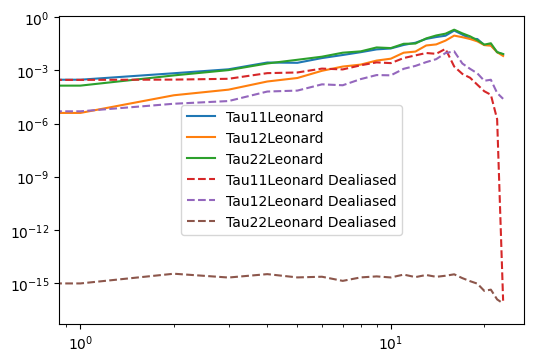

Re20kNX1024nx4ny0r0p1   65
Mean maximum absolute value of all Leonard stress components - Dealiased : 0.010995823854849013
Mean maximum absolute value of all Leonard stress components - aliased   : 0.18102998183786
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.12283404378327782
Mean maximum absolute value of all Cross stress components - aliased     : 0.12283404378327772
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.021983851228520094
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.021983851214656236


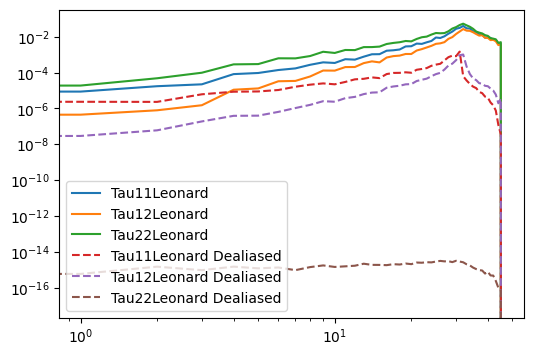

Re20kNX1024nx4ny0r0p1   129
Mean maximum absolute value of all Leonard stress components - Dealiased : 0.00746206782709441
Mean maximum absolute value of all Leonard stress components - aliased   : 0.12718404792185453
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.08949893980031219
Mean maximum absolute value of all Cross stress components - aliased     : 0.08949893980031211
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.015071719868683948
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.015071719839225948


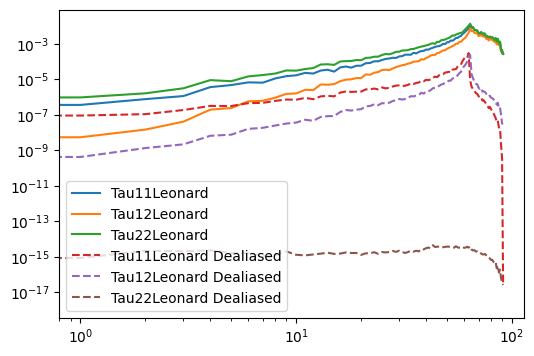

Re20kNX1024nx4ny0r0p1   257
Mean maximum absolute value of all Leonard stress components - Dealiased : 0.005615001847816062
Mean maximum absolute value of all Leonard stress components - aliased   : 0.09666481751447227
Mean maximum absolute value of all Cross stress components - Dealiased   : 0.06812599564537543
Mean maximum absolute value of all Cross stress components - aliased     : 0.06812599564537535
Mean maximum absolute value of all Reynolds stress components - Dealiased: 0.011353776937230116
Mean maximum absolute value of all Reynolds stress components - aliased  : 0.011353776937211782


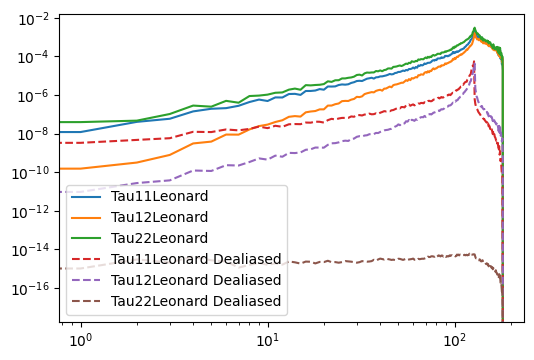

In [1]:
from py2d.SGSterms import TauLeonard, TauCross, TauReynolds, Tau
from py2d.spectra import spectrum_angled_average
from py2d.util import regrid

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.io import loadmat
import numpy as np


# Define parameters 
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'
Lx, Ly = 2*np.pi, 2*np.pi

# Load the data from the file
data = loadmat(filename)
# Extract the Omega data from the file
Omega_DNS = data['Omega']

gridType = 'odd'
if gridType == 'even':
    N_DNS = nx
else:
    Omega_DNS = regrid(Omega_DNS, nx+1, nx+1)
    N_DNS = nx+1

# Following code tests the accurancy of the SGS decomposition code by ensuring that the sum of Leonard, Cross, and Reynolds is equal to SGS term
print("Testing for dealiasing")
print("The dealiased Leonard stress (coarse grained) for spectral_square filter is zero, ")

dataType = 'Re20kNX1024nx4ny0r0p1' #  Re20kNX1024nx4ny0r0p1 Re20kNX1024nx4ny0r0p01 Re20kNX1024nx25ny25r0p1 Re100kNX2048nx4ny0r0p1

# Initialize filter and coarse grain types for SGS terms calculation
filterType = 'spectral-square' # guaissian, spectral, spectral-square
coarseGrainType = 'spectral'

totalsnap = 1

# Initialize
max_TauLeonard = []
max_TauCross = []
max_TauReynolds = []
max_TauLeonard_dealiased = []  
max_TauCross_dealiased = []
max_TauReynolds_dealiased = []
spectra_TauLeonard11 = []
spectra_TauLeonard12 = []
spectra_TauLeonard22 = []
spectra_TauLeonard11_dealiased = []
spectra_TauLeonard12_dealiased = []
spectra_TauLeonard22_dealiased = []

# Loop over different grid sizes to test the accuracy of SGS decomposition
for k in [32, 64, 128, 256]:

    if gridType == 'even':
        k = k
    else:
        k = k+1

    N_LES = k * [1, 1]
    Delta = 2 * Lx / N_LES[0]

    # Calculate the LES grid size and filter width (Delta)
    N_LES = np.array([k, k])
    Delta = 2 * Lx / N_LES[0]  # Assuming Lx is defined elsewhere as the domain size

    for countSnap in range(totalsnap):

        # Compute the SGS terms without and with dealiasing
        Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11_dealiased, Tau12_dealiased, Tau22_dealiased = Tau(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        # Compute individual SGS terms (Leonard, Cross, Reynolds) without and with dealiasing
        Tau11Leonard, Tau12Leonard, Tau22Leonard = TauLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11Leonard_dealiased, Tau12Leonard_dealiased, Tau22Leonard_dealiased = TauLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        Tau11Cross, Tau12Cross, Tau22Cross = TauCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11Cross_dealiased, Tau12Cross_dealiased, Tau22Cross_dealiased = TauCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        Tau11Reynolds, Tau12Reynolds, Tau22Reynolds = TauReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
        Tau11Reynolds_dealiased, Tau12Reynolds_dealiased, Tau22Reynolds_dealiased = TauReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

        TauLeonard11_abs_hat = np.sqrt(np.fft.fft2(Tau11Leonard)*np.conj(np.fft.fft2(Tau11Leonard)))
        TauLeonard12_abs_hat = np.sqrt(np.fft.fft2(Tau12Leonard)*np.conj(np.fft.fft2(Tau12Leonard)))
        TauLeonard22_abs_hat = np.sqrt(np.fft.fft2(Tau22Leonard)*np.conj(np.fft.fft2(Tau22Leonard)))

        TauLeonard11_abs_hat_dealiased = np.sqrt(np.fft.fft2(Tau11Leonard_dealiased)*np.conj(np.fft.fft2(Tau11Leonard_dealiased)))
        TauLeonard12_abs_hat_dealiased = np.sqrt(np.fft.fft2(Tau12Leonard_dealiased)*np.conj(np.fft.fft2(Tau12Leonard_dealiased)))
        TauLeonard22_abs_hat_dealiased = np.sqrt(np.fft.fft2(Tau22Leonard_dealiased)*np.conj(np.fft.fft2(Tau22Leonard_dealiased)))

        kmax = 'diagonal'
        spectra_TauLeonard11, k = spectrum_angled_average(TauLeonard11_abs_hat, spectral=True, kmax=kmax)
        spectra_TauLeonard12, k = spectrum_angled_average(TauLeonard12_abs_hat, spectral=True, kmax=kmax)
        spectra_TauLeonard22,k = spectrum_angled_average(TauLeonard22_abs_hat, spectral=True, kmax=kmax)

        spectra_TauLeonard11_dealiased, k = spectrum_angled_average(TauLeonard11_abs_hat_dealiased, spectral=True, kmax=kmax)
        spectra_TauLeonard12_dealiased, k = spectrum_angled_average(TauLeonard12_abs_hat_dealiased, spectral=True, kmax=kmax)
        spectra_TauLeonard22_dealiased,k = spectrum_angled_average(TauLeonard22_abs_hat_dealiased, spectral=True, kmax=kmax)

        max_TauLeonard.append(np.max([np.max(np.abs(Tau11Leonard)), np.max(np.abs(Tau12Leonard)), np.max(np.abs(Tau22Leonard))]))
        max_TauCross.append(np.max([np.max(np.abs(Tau11Cross)), np.max(np.abs(Tau12Cross)), np.max(np.abs(Tau22Cross))]))
        max_TauReynolds.append(np.max([np.max(np.abs(Tau11Reynolds)), np.max(np.abs(Tau12Reynolds)), np.max(np.abs(Tau22Reynolds))]))

        max_TauLeonard_dealiased.append(np.max([np.max(np.abs(Tau11Leonard_dealiased)), np.max(np.abs(Tau12Leonard_dealiased)), np.max(np.abs(Tau22Leonard_dealiased))]))
        max_TauCross_dealiased.append(np.max([np.max(np.abs(Tau11Cross_dealiased)), np.max(np.abs(Tau12Cross_dealiased)), np.max(np.abs(Tau22Cross_dealiased))]))
        max_TauReynolds_dealiased.append(np.max([np.max(np.abs(Tau11Reynolds_dealiased)), np.max(np.abs(Tau12Reynolds_dealiased)), np.max(np.abs(Tau22Reynolds_dealiased))]))

    print(dataType + '   ' + str(N_LES[0]))
    print('Mean maximum absolute value of all Leonard stress components - Dealiased :', np.mean(max_TauLeonard_dealiased))
    print('Mean maximum absolute value of all Leonard stress components - aliased   :', np.mean(max_TauLeonard))
    print('Mean maximum absolute value of all Cross stress components - Dealiased   :', np.mean(max_TauCross_dealiased))
    print('Mean maximum absolute value of all Cross stress components - aliased     :', np.mean(max_TauCross))
    print('Mean maximum absolute value of all Reynolds stress components - Dealiased:', np.mean(max_TauReynolds_dealiased))
    print('Mean maximum absolute value of all Reynolds stress components - aliased  :', np.mean(max_TauReynolds))

    fig_spectrum, axs_spectrum = plt.subplots(nrows=1,ncols=1, figsize=(6, 4))

    axs_spectrum.loglog(k, spectra_TauLeonard11, label='Tau11Leonard')
    axs_spectrum.loglog(k, spectra_TauLeonard12, label='Tau12Leonard')
    axs_spectrum.loglog(k, spectra_TauLeonard22, label='Tau22Leonard')
    axs_spectrum.loglog(k, spectra_TauLeonard11_dealiased, '--', label='Tau11Leonard Dealiased')
    axs_spectrum.loglog(k, spectra_TauLeonard12_dealiased, '--', label='Tau12Leonard Dealiased')
    axs_spectrum.loglog(k, spectra_TauLeonard22_dealiased, '--', label='Tau22Leonard Dealiased')
    axs_spectrum.legend()
    plt.show()
#     print("Aliased   norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds", norm_Tau11, norm_Tau11Leonard, norm_Tau11Cross, norm_Tau11Reynolds) 
#     print("DeAliased norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds", norm_Tau11_dealiased, norm_Tau11Leonard_dealiased, norm_Tau11Cross_dealiased, norm_Tau11Reynolds_dealiased)
#     print("##########################################################")


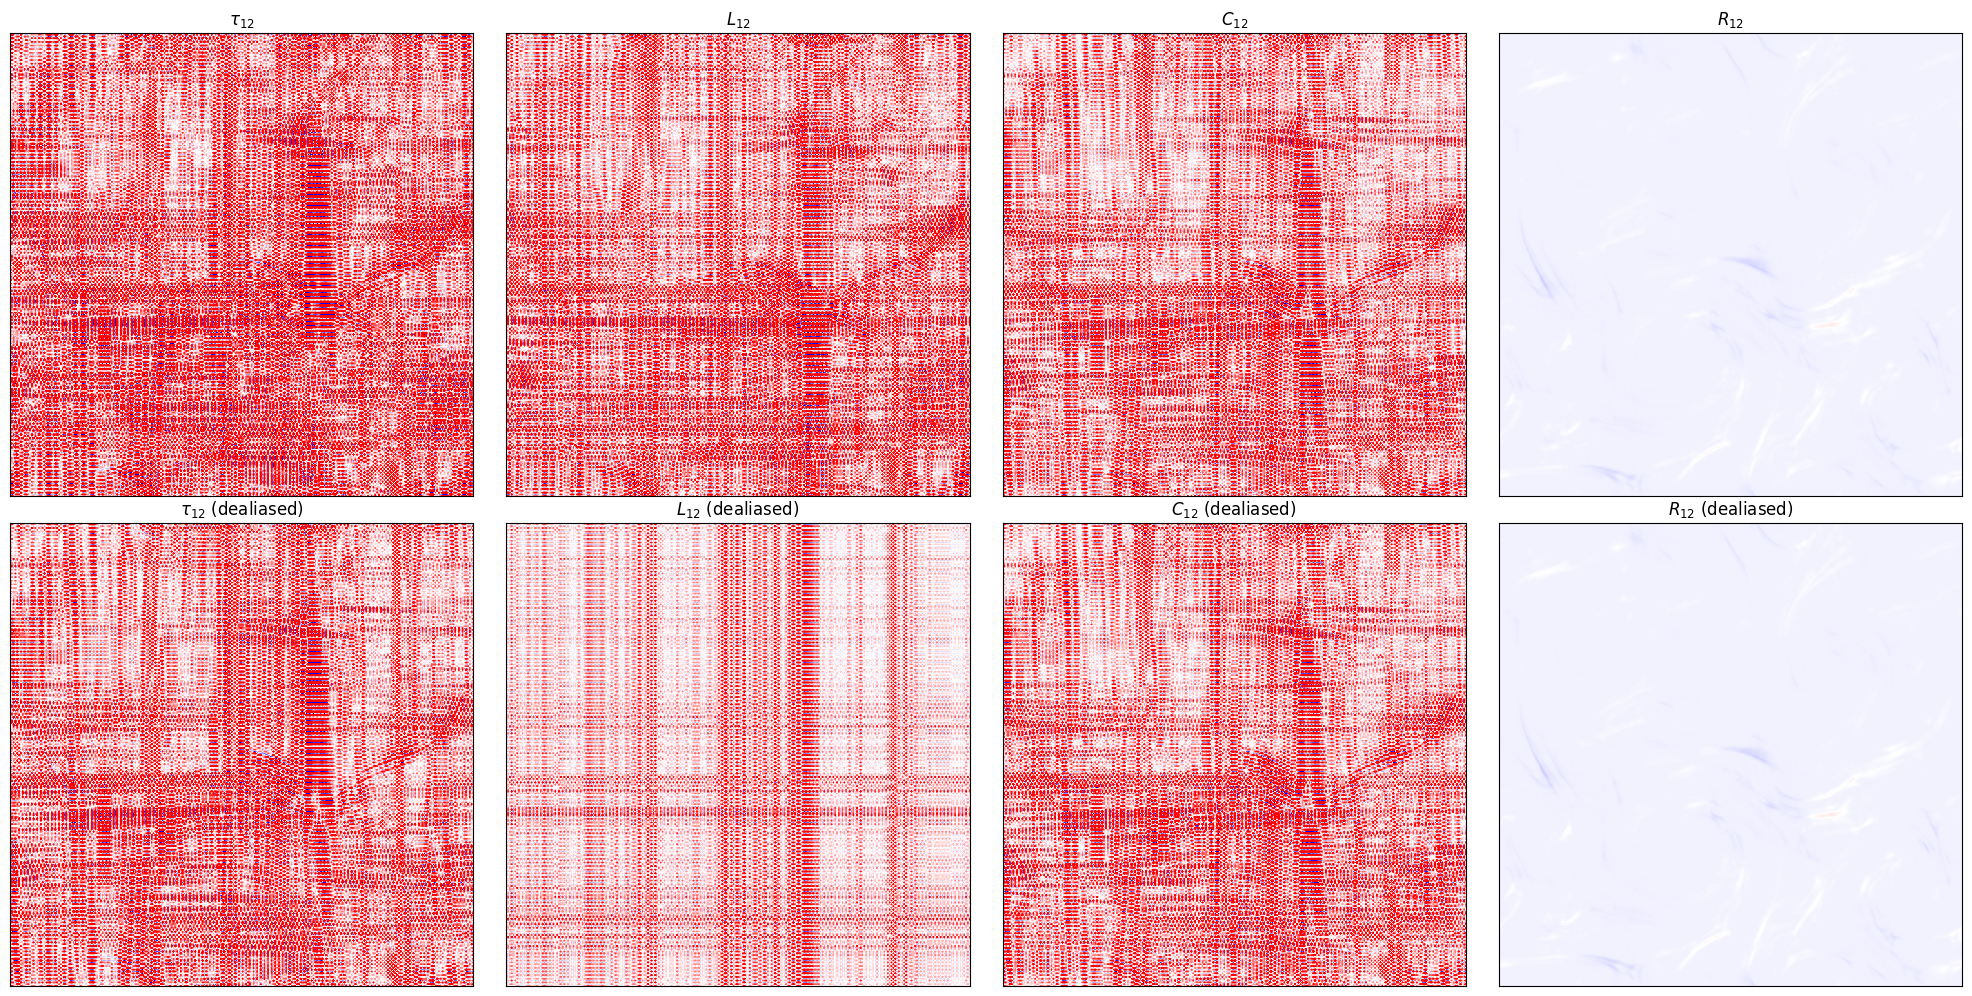

In [5]:
# Plot contour of stresses

# Plot contours of all computed SGS terms
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Determine common limits for color scaling
vmin = 0.1*min(Tau12.min(), Tau12Leonard.min(), Tau12Cross.min(), Tau12Reynolds.min(), 
        Tau12_dealiased.min(), Tau12Leonard_dealiased.min(), Tau12Cross_dealiased.min(), Tau12Reynolds_dealiased.min())
vmax = 0.1*max(Tau12.max(), Tau12Leonard.max(), Tau12Cross.max(), Tau12Reynolds.max(), 
        Tau12_dealiased.max(), Tau12Leonard_dealiased.max(), Tau12Cross_dealiased.max(), Tau12Reynolds_dealiased.max())

# Titles for each subplot
titles = ['$\\tau_{12}$', '$L_{12}$', '$C_{12}$', '$R_{12}$', '$\\tau_{12}$ (dealiased)', '$L_{12}$ (dealiased)', '$C_{12}$ (dealiased)', '$R_{12}$ (dealiased)']

# First row - non-dealiased terms
axs[0, 0].contourf(Tau12, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[0, 1].contourf(Tau12Leonard, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[0, 2].contourf(Tau12Cross, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[0, 3].contourf(Tau12Reynolds, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)

# Second row - dealiased terms
axs[1, 0].contourf(Tau12_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[1, 1].contourf(Tau12Leonard_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[1, 2].contourf(Tau12Cross_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
axs[1, 3].contourf(Tau12Reynolds_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)

# Set titles and make layout adjustments
for ax, title in zip(axs.flat, titles ):
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

0.904118267436695 0.7518809663389823 0.48070801256605017 6.627833995081246e-05 0.39891640004128787
6.273439624470456e-17
0.9510177763402918 0.8359974252547586 0.3892604771912522 3.2243988625265795e-06 0.17417912876551148
7.567559395291683e-17
0.9634970331165135 0.8883138874297011 0.32134377795514296 8.381190519691886e-08 0.05587405172958224
2.2485027139714324e-17
0.9692607258951349 0.9137068020339724 0.2825320461235954 1.6158776041571532e-09 0.015476222338677872
9.694003239043523e-18
0.9871565924488033 0.9655376613946668 0.1793885989408429 1.0706548022266769e-11 0.002516234278638554
3.748964841845057e-18


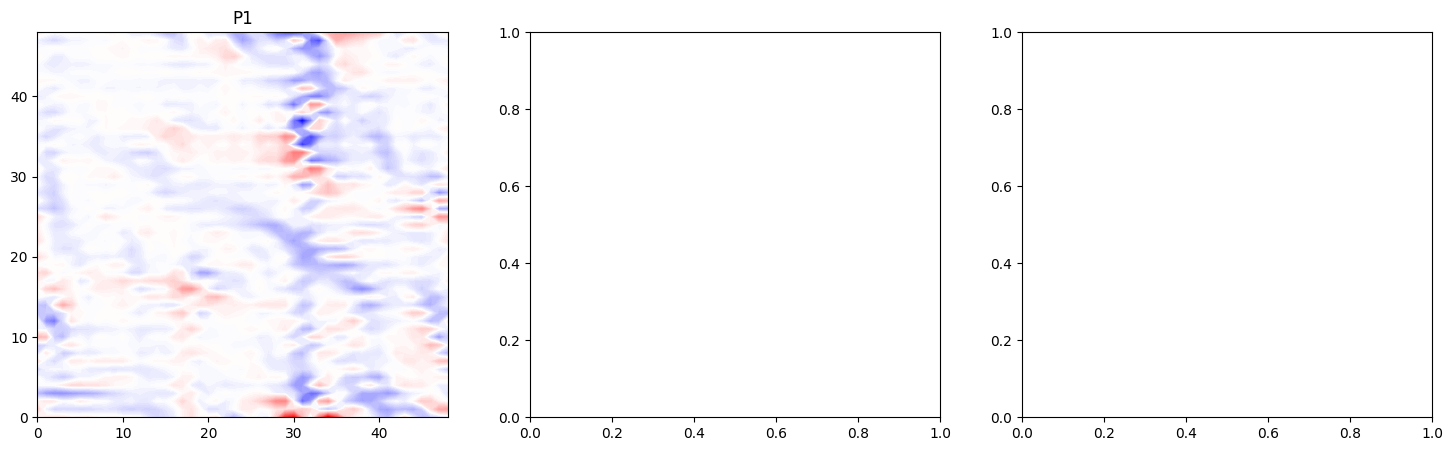

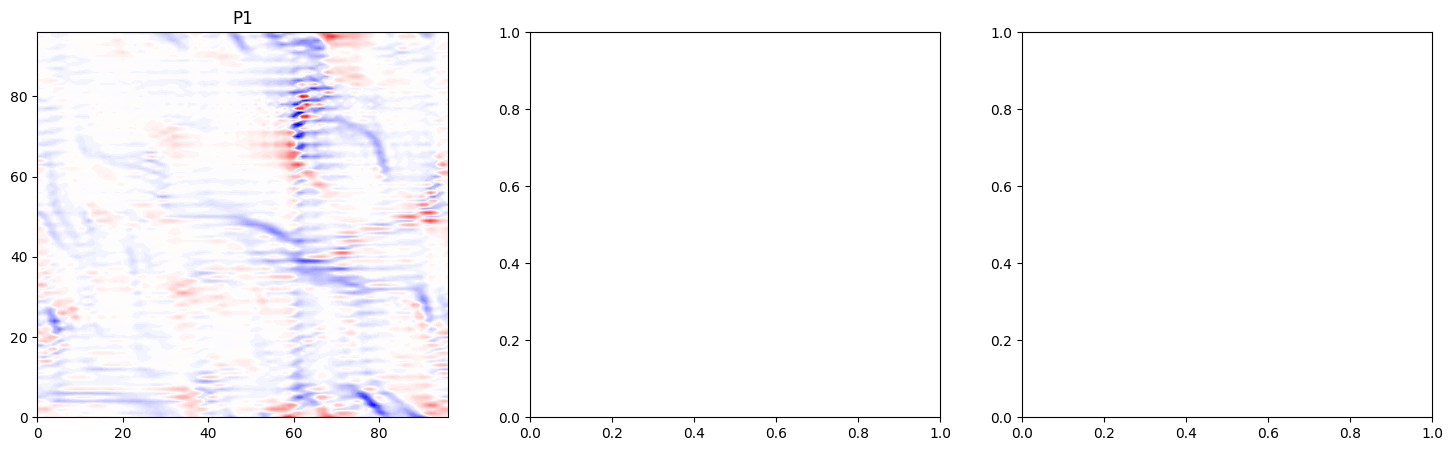

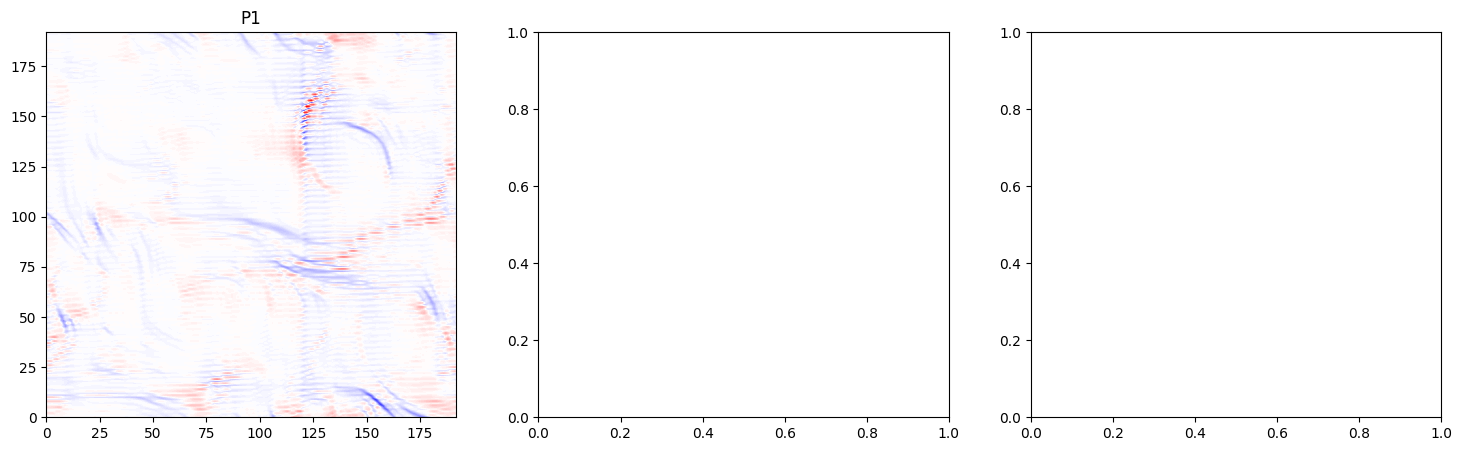

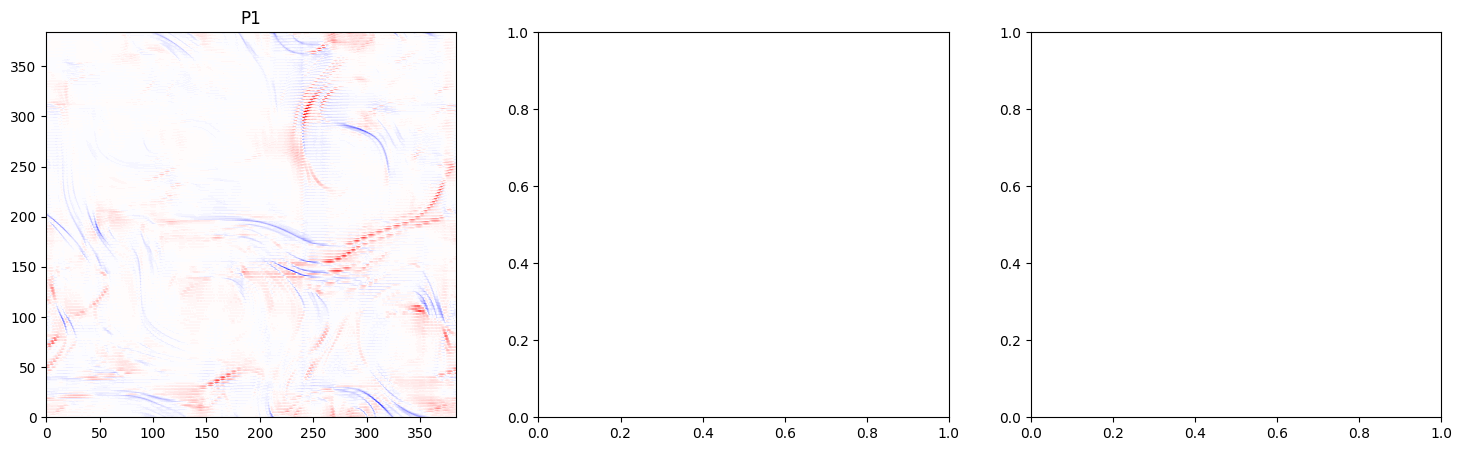

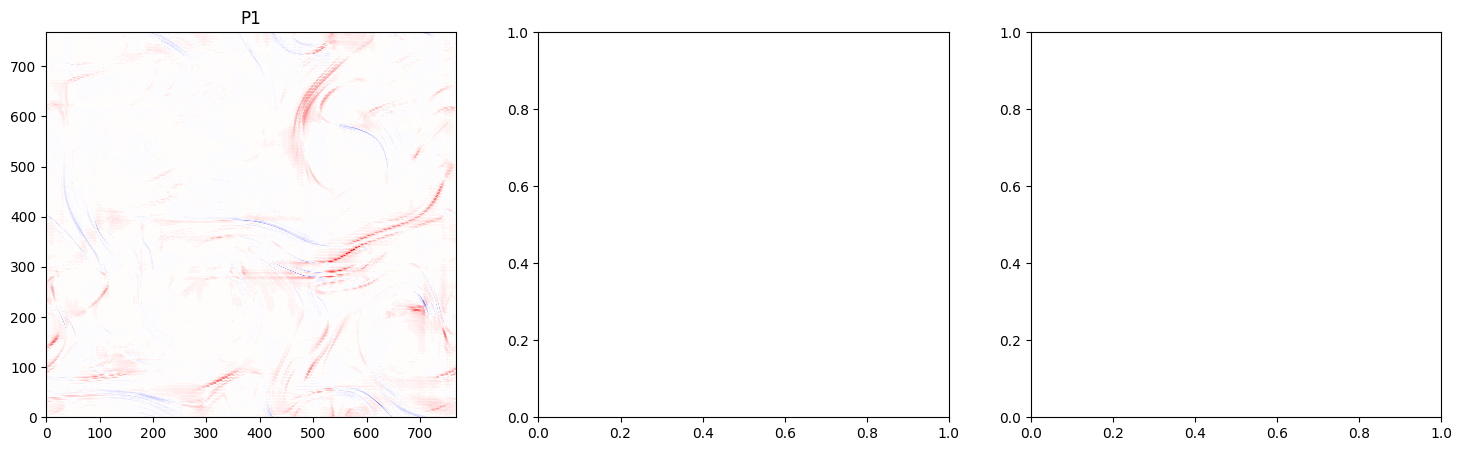

In [8]:
# Test: Correlation Coefficient of P_Tau increases with increasing grid size
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

from py2d.SGSterms import Tau,  Sigma
from py2d.filter import filter2D, coarse_spectral_filter_square
from py2d.dealias import multiply_dealias, padding_for_dealias
from py2d.apriori_analysis import energyTransfer, enstrophyTransfer, corr2
from py2d.convert import Omega2Psi, Psi2UV, strain_rate
from py2d.initialize import initialize_wavenumbers_rfft2
from py2d.derivative import derivative


def energyTransfer(A,B, Tauxx, Tauxy, Tauyy, Kx, Ky, dealias=False):
    
    Ax = derivative(A, [1,0], Kx, Ky)
    Ay = derivative(A, [0,1], Kx, Ky)
    Bx = derivative(B, [1,0], Kx, Ky)

    Tauxx_Ax = multiply_dealias(Tauxx, Ax, dealias=dealias)
    Tauxy_Ay = multiply_dealias(Tauxy, Ay, dealias=dealias)
    Tauxy_Bx = multiply_dealias(Tauxy, Bx, dealias=dealias)
    Tauyy_Ax = multiply_dealias(Tauyy, Ax, dealias=dealias)

    # Tauxx_Tauyy_Ax = multiply_dealias((Tauxx-Tauyy), Ax, dealias=dealias)
    # Tauxy_Ay_Bx = multiply_dealias(Tauxy, Ay+Bx, dealias=dealias)

    # ee = -Tauxx_Tauyy_Ax - Tauxy_Ay_Bx
    ee = -(Tauxx_Ax-Tauyy_Ax) - (Tauxy_Ay+Tauxy_Bx)

    # ee = -Tauxx*Ux + Tauyy*Ux - Tauxy*Uy - Tauxy*Vx
    return ee

def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred)/np.linalg.norm(y_true)


dataType = 'Re20kNX1024nx4ny0r0p1' 
DATA_DIR = '../../data/2D_FHIT/' + dataType + '/DNS/train1/DNS1.mat'

with h5py.File(DATA_DIR, 'r') as f:
    Omega_Arr = np.array(f['slnWorDNS']).T

gridType = 'odd'
filterType = 'gaussian'
coarseGrainType = 'spectral'

totalSnap = 1
dealias = True
Lx = 2*np.pi

for N_LES in [32, 64, 128, 256, 512]:

    corr_PTau_FDNS_GM4 = []
    corr_PZ_FDNS_GM4 = []

    if 'Re20k' in dataType:
        dt_DNS = 5e-5
        N_DNS = int(1024)
    elif 'Re100k' in dataType:
        dt_DNS = 2e-5
        N_DNS = 2048


    if gridType == 'even':
        N_DNS = nx
    else:
        N_DNS = nx+1
        N_LES = N_LES +1

    if coarseGrainType == None:
        Ngrid = [N_DNS, N_DNS]
    else:   
        Ngrid = [N_LES, N_LES]

    Kx_DNS, Ky_DNS, _, _, invKsq_DNS = initialize_wavenumbers_rfft2(N_DNS, N_DNS, Lx, Lx, INDEXING='ij')
    Kx, Ky, _, _, invKsq = initialize_wavenumbers_rfft2(Ngrid[0], Ngrid[1], Lx, Lx, INDEXING='ij')

    Delta = 2*Lx/N_LES

    corr_PTau_FDNS_GM4 = []
    corr_PZ_FDNS_GM4 = []


    for countSnap in range(totalSnap):

        Omega_DNS = Omega_Arr[:,:,countSnap]

        if gridType == 'even':
            pass
        else:
            Omega_DNS = regrid(Omega_DNS, N_DNS, N_DNS)

        Psi_DNS = Omega2Psi(Omega_DNS, invKsq=invKsq_DNS)
        U_DNS, V_DNS = Psi2UV(Psi_DNS, Kx_DNS, Ky_DNS)

        Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filterType, coarseGrainType=None, Delta=Delta, N_LES=Ngrid, dealias=dealias)

        U = filter2D(U_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, Ngrid=Ngrid)
        V = filter2D(V_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, Ngrid=Ngrid)
        Psi = filter2D(Psi_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, Ngrid=Ngrid)
        Omega = filter2D(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, Ngrid=Ngrid)

        Ngrid_dealias = [int(N_LES*3/2), int(N_LES*3/2)]
        Tau11_pad = filter2D(Tau11, filterType=None, coarseGrainType='spectral', Ngrid=Ngrid_dealias)
        Tau12_pad = filter2D(Tau12, filterType=None, coarseGrainType='spectral', Ngrid=Ngrid_dealias)
        Tau22_pad = filter2D(Tau22, filterType=None, coarseGrainType='spectral', Ngrid=Ngrid_dealias)


        

        # Tau11_GM4, Tau12_GM4, Tau22_GM4 = TauGM4(U, V, Kx=Kx, Ky=Ky, Delta=Delta, dealias=dealias)

        # P1 = energyTransfer(U, V, Tau11, Tau12, Tau22, Kx, Ky, dealias=True)
        # Px = energyTransfer(U, V, Tau11, Tau12, Tau22, Kx, Ky, dealias=False)
        # print('norm P1', np.linalg.norm(P1), np.linalg.norm(Px))
        # P1_GM4 = energyTransfer(U, V, Tau11_GM4, Tau12_GM4, Tau22_GM4, Kx, Ky, dealias=dealias)

        Ux_nopad = derivative(U, [1,0], Kx, Ky)
        Uy_nopad = derivative(U, [0,1], Kx, Ky)
        Vx_nopad = derivative(V, [1,0], Kx, Ky)
        Uxx_nopad = derivative(U, [2,0], Kx, Ky)
        Uyy_nopad = derivative(U, [0,2], Kx, Ky)
        Uxy_nopad = derivative(U, [1,1], Kx, Ky)
        Vxx_nopad = derivative(V, [2,0], Kx, Ky)

        Ux = padding_for_dealias(Ux_nopad)
        Uy = padding_for_dealias(Uy_nopad)
        Vx = padding_for_dealias(Vx_nopad)
        Vy = -Ux
        Uxx = padding_for_dealias(Uxx_nopad)
        Uyy = padding_for_dealias(Uyy_nopad)
        Uxy = padding_for_dealias(Uxy_nopad)
        Vxx = padding_for_dealias(Vxx_nopad)
        Vxy = -Uxx
        Vyy = -Uxy

        A = Delta**2/12
        B1 = Delta**4/144
        B2 = Delta**4/288

        Tau11GM2 = A*(Ux**2 + Uy**2)
        Tau12GM2 = A*(Ux*Vx + Uy*Vy)
        Tau22GM2 = A*(Vx**2 + Vy**2)
        Tau11GM4 = Tau11GM2 + B2*(Uxx**2 + Uyy**2) + B1*(Uxy**2)
        Tau12GM4 = Tau12GM2 + B2*(Uxx*Vxx + Uyy*Vyy) + B1*(Uxy*Vxy)
        Tau22GM4 = Tau22GM2 + B2*(Vxx**2 + Vyy**2) + B1*(Vxy**2)

        PGM2_pad = (Tau11GM2-Tau22GM2)*Ux + Tau12GM2*(Uy+Vx)
        PGM2_hat = coarse_spectral_filter_square(np.fft.rfft2(PGM2_pad), Ux_nopad.shape[0])
        P1_GM2 = -np.fft.irfft2(PGM2_hat, s=[Tau11GM2.shape[0], Tau11GM2.shape[0]])

        PGM4_pad = (Tau11GM4-Tau22GM4)*Ux + Tau12GM4*(Uy+Vx)
        PGM4_hat = coarse_spectral_filter_square(np.fft.rfft2(PGM4_pad), Ux_nopad.shape[0])
        P1_GM4 = -np.fft.irfft2(PGM4_hat, s=[Tau11GM4.shape[0], Tau11GM4.shape[0]])


        P1_pad = (Tau11_pad-Tau22_pad)*Ux + Tau12_pad*(Uy+Vx)
        P1_hat = coarse_spectral_filter_square(np.fft.rfft2(P1_pad), Ux_nopad.shape[0])
        P1 = -np.fft.irfft2(P1_hat, s=[Tau11_pad.shape[0], Tau11_pad.shape[0]])



        A1 = mean_squared_error(P1.flatten(), P1_GM4.flatten())

        B1 = r2_score(P1.flatten(), P1_GM4.flatten())

        C1 = RMSE(P1, P1_GM4)

        print(corr2(P1, P1_GM4), B1, C1, A1, np.linalg.norm(P1-P1_GM4))
        print(np.max(np.abs(P1_GM2)))

        # Plot contour with cmap = bwr, of P1, P1_GM4, and P1-P1_GM4
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        vmax = np.max([np.max(P1), np.max(P1_GM4)])
        vmin = -vmax
        axs[0].contourf(P1, cmap='bwr', levels=100, vmax=vmax, vmin=vmin)
        axs[0].set_title('P1')


           